# imports

In [15]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from torchviz import make_dot



# vars

In [16]:
df = pd.read_csv("images_text.csv")
w2v_model = Word2Vec.load("word2vec.model")
print(len(w2v_model.wv))
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LR = 0.001
BATCH_SIZE = 1
EMBEDDING_MATRIX = w2v_model.wv.vectors
NUM_CLASSES = 3
EPOCHS = 20
HIDDEN_SIZE = 50
SEQUECE_LENGTH = 100
VOCAB_SIZE, EMBEDDING_SIZE = w2v_model.wv.vectors.shape


13015


# LSTM1

In [18]:
class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        vocab_size, embedding_dim = EMBEDDING_MATRIX.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(EMBEDDING_MATRIX), freeze=True)
        self.dropout = nn.Dropout(0.5)
        self.lstm1 = nn.LSTM(embedding_dim, HIDDEN_SIZE, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(HIDDEN_SIZE * 2, NUM_CLASSES)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        output1, _ = self.lstm1(embedded)
        last_hidden_state = torch.cat((output1[:, -1, :HIDDEN_SIZE], output1[:, 0, HIDDEN_SIZE:]), dim=1)
        logits = self.fc(last_hidden_state)
        return logits

class TextDataset(Dataset):
    def __init__(self, dataframe, text_column, label_column, word2vec_model):
        self.data = dataframe[text_column].tolist()
        self.labels = dataframe[label_column].tolist()
        self.word2vec_model = word2vec_model
        self.max_sequence_length = SEQUECE_LENGTH

        
    def __getitem__(self, index):

        sequence = self.data[index]
        label = self.labels[index]
        tokens = word_tokenize(sequence)
        sequence_indices = [self.word2vec_model.wv.key_to_index[word] for word in tokens if word in self.word2vec_model.wv]
        padded_sequence = torch.tensor(sequence_indices + [0] * (self.max_sequence_length - len(sequence_indices)))[:self.max_sequence_length]
        
        return padded_sequence, label

    def __len__(self):
        return len(self.data)

# visualisation

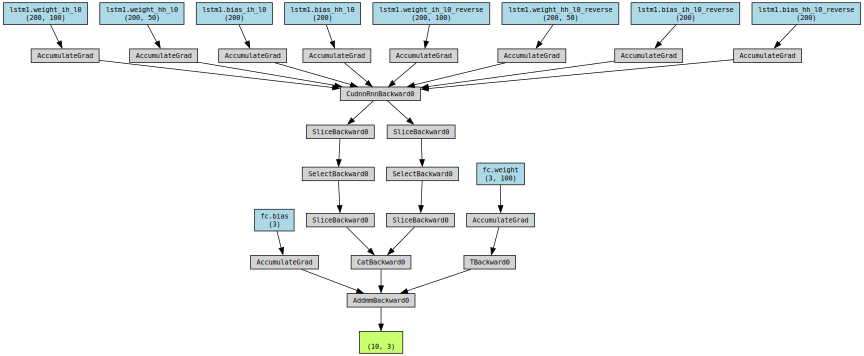

In [13]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'


BATCH_SIZE = 10

data = TextDataset(df, "text_emo", "label", w2v_model)
indices = np.arange(len(data))

# split
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)

# loader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


# model
model = TextClassifier().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

text, label = next(iter(train_loader))
output = model(text.to(DEVICE))

make_dot(output, params=dict(model.named_parameters()))

# functions

In [19]:
dic = {0: "negative", 1: "neutral", 2: "positive"}

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for batch_idx, (text, label) in enumerate(train_loader):
        text, label = text.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(text)
        loss = criterion(output, label)
        acc = accuracy(output, label)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc.item()

    return running_loss / len(train_loader), running_acc / len(train_loader)


def predict(model, text, device, word2vec_model, label=None):
    max_sequence_length = SEQUECE_LENGTH
    model.eval()
    sequence = text
    label = label
    tokens = word_tokenize(sequence)
    sequence_indices = [word2vec_model.wv.key_to_index[word] for word in tokens if word in word2vec_model.wv]
    padded_sequence = torch.tensor(sequence_indices + [0] * (max_sequence_length - len(sequence_indices)))[:max_sequence_length].unsqueeze(0)
    with torch.no_grad():
        predict_text = padded_sequence.to(device)
        output = model(predict_text)
        result = torch.max(output, dim=1).indices[0].cpu().item()
        
        print("predicted label:", dic[result])
        if label != None:
            print("actual label:", dic[label])
    return output, result

def val(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for batch_idx, (text, label) in enumerate(test_loader):
            text, label = text.to(device), label.to(device)

            output = model(text)
            loss = criterion(output, label)
            acc = accuracy(output, label)

            running_loss += loss.item()
            running_acc += acc.item()

    return running_loss / len(test_loader), running_acc / len(test_loader)

def test(model, predict_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch_idx, (text, label) in enumerate(predict_loader):
            text, label = text.to(device), label.to(device)

            output = model(text)
            loss = criterion(output, label)
            acc = accuracy(output, label)

            running_loss += loss.item()
            running_acc += acc.item()

            _, preds = torch.max(output, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label.cpu().numpy())

        

    avg_loss = running_loss / len(predict_loader)
    avg_acc = running_acc / len(predict_loader)

    return avg_loss, avg_acc, predictions, true_labels

def save_model(model, save_dir, filename):
    torch.save(model.state_dict(), os.path.join(save_dir, filename))

# model def

In [159]:
# Data set

BATCH_SIZE = 1024

data = TextDataset(df, "text_emo", "label", w2v_model)
indices = np.arange(len(data))

# split
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)

# loader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


# model
model = TextClassifier().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

cuda:0
NVIDIA GeForce GTX 1650


TextClassifier(
  (embedding): Embedding(13015, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm1): LSTM(100, 50, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)

# train

In [161]:
best_val_acc = 0.0
count = 0
val_acc_list = []
train_acc_list = []
val_loss_list = []
train_loss_list = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = val(model, test_loader, criterion, DEVICE)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    
    print(
        f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )
    

    if val_acc > best_val_acc:
        print(f"New best model! Saving...")
        save_model(model, ".", "Text_best_model.pt")
        best_val_acc = val_acc
        print(f"Best val acc: {best_val_acc:.4f}")
        count = 0
    else:
        count += 1
        print(f"Count: {count} of epochs have no improvement")
        if count == 5:
            print(f"Early stopping, best val acc: {best_val_acc:.4f}")
            break


Epoch: 1/20, Train Loss: 0.5868, Train Acc: 0.7652, Val Loss: 0.3141, Val Acc: 0.8863
New best model! Saving...
Best val acc: 0.8863
Epoch: 2/20, Train Loss: 0.3770, Train Acc: 0.8566, Val Loss: 0.2741, Val Acc: 0.8987
New best model! Saving...
Best val acc: 0.8987
Epoch: 3/20, Train Loss: 0.3422, Train Acc: 0.8705, Val Loss: 0.2593, Val Acc: 0.9048
New best model! Saving...
Best val acc: 0.9048
Epoch: 4/20, Train Loss: 0.3228, Train Acc: 0.8773, Val Loss: 0.2451, Val Acc: 0.9105
New best model! Saving...
Best val acc: 0.9105
Epoch: 5/20, Train Loss: 0.3118, Train Acc: 0.8823, Val Loss: 0.2446, Val Acc: 0.9103
Count: 1 of epochs have no improvement
Epoch: 6/20, Train Loss: 0.3034, Train Acc: 0.8853, Val Loss: 0.2323, Val Acc: 0.9157
New best model! Saving...
Best val acc: 0.9157
Epoch: 7/20, Train Loss: 0.2956, Train Acc: 0.8882, Val Loss: 0.2302, Val Acc: 0.9165
New best model! Saving...
Best val acc: 0.9165
Epoch: 8/20, Train Loss: 0.2896, Train Acc: 0.8912, Val Loss: 0.2262, Val Acc

# learning rate

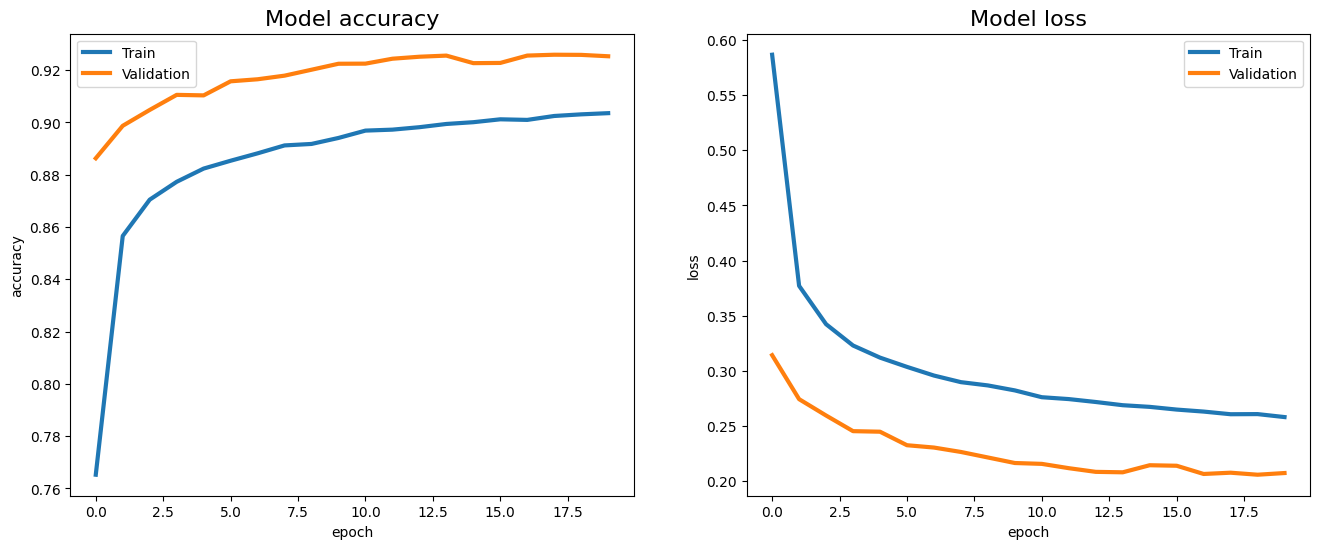

In [162]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
# summarize history for accuracy
axis1.plot(train_acc_list, label='Train', linewidth=3)
axis1.plot(val_acc_list, label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

axis2.plot(train_loss_list, label='Train', linewidth=3)
axis2.plot(val_loss_list, label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

# predict

In [26]:
model = TextClassifier().to(DEVICE)
model.load_state_dict(torch.load("Text_best_model.pt"))
predict(model, "", DEVICE, w2v_model, 0)


predicted label: neutral
actual label: negative


(tensor([[ 0.2295,  1.8907, -1.9231]], device='cuda:0'), 1)

# test

              precision    recall  f1-score   support

    negative       0.90      0.94      0.92     17934
     neutral       0.94      0.90      0.92     18039
    positive       0.94      0.94      0.94     18027

    accuracy                           0.93     54000
   macro avg       0.93      0.93      0.93     54000
weighted avg       0.93      0.93      0.93     54000



Text(0.5, 1.0, 'The Confusion Martrix of Text model')

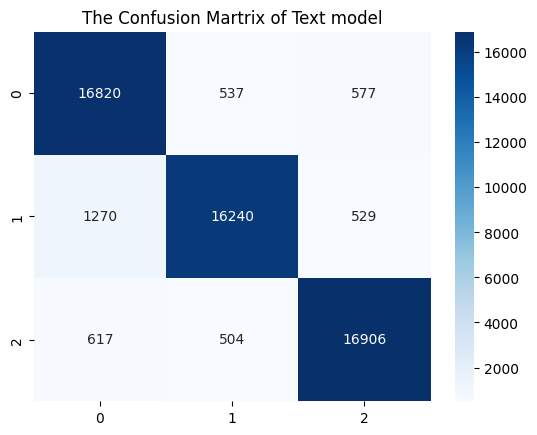

In [192]:

test_loss, test_acc, predictions, true_labels = test(model, test_loader, criterion, DEVICE)

print(f"Test Acc: {test_acc:.4f}")

true_labels = [dic[i] for i in true_labels]
predictions = [dic[i] for i in predictions]

print(classification_report(true_labels,predictions))
cm = confusion_matrix(true_labels,predictions, labels=["negative", "neutral", "positive"])
p = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('The Confusion Martrix of Text model')
